In [12]:
%pip install flatten_json pymongo pandas sklearn matplotlib np xgboost seaborn
import pandas as pd
import pymongo
import sklearn
from flatten_json import flatten
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 4.8 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [19]:
# version we want: Version 12.18.468.3251 (Sep 16 2022/13:11:56) [PUBLIC] <Releases/12.18>

mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_database = mongo_client["tft_data"]
mongo_container = mongo_database["challenger"]
version = 'Version 12.18.468.3251 (Sep 16 2022/13:11:56) [PUBLIC] <Releases/12.18>'

all_data = list(mongo_container.find({"info.game_version": version}))

In [20]:
df = pd.json_normalize(all_data, ["info", "participants"], ["metadata"])

df['played_with_partner'] = np.where(np.isnan(df['partner_group_id']), False, True)

# drop columns gold_left, last_round, level, players_eliminated, time_eliminated, total_damage_to_players, traits, units  
df = df.drop(columns=['gold_left', 'last_round', 'level', 'players_eliminated', 'time_eliminated', 'total_damage_to_players'])

# drop columns starting with companion
df = df.loc[:, ~df.columns.str.startswith('companion')]

df['match_id'] = df['metadata'].apply(lambda x: x['match_id'])
df = df.drop(columns=['metadata', 'partner_group_id'])

def get_augment_at_position(row, position):
    return row[position] if len(row) > position else None

# create new columns with items of augments column
df['augment_1'] = df['augments'].apply(get_augment_at_position, position=0)
df['augment_2'] = df['augments'].apply(get_augment_at_position, position=1)
df['augment_3'] = df['augments'].apply(get_augment_at_position, position=2)
df = df.drop(columns=['augments'])

# drop colum traits
df = df.drop(columns=['traits'])

# add a column "top4" that is true if placement is 1,2,3 or 4 
df['top4'] = np.where(df['placement'] <= 4, True, False)

def units_object_array_to_unit_array_without_items(unit_object_array):
    return [f"{unit['character_id'].replace('TFT7_', '')}_{unit['tier']}" for unit in unit_object_array]

df['units'] = df['units'].apply(units_object_array_to_unit_array_without_items)

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('units')),  # type: ignore
                          columns=mlb.classes_,
                          index=df.index))
df_start = df

/home/sebastian/dev/teamfight-tactis-data-crawler/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


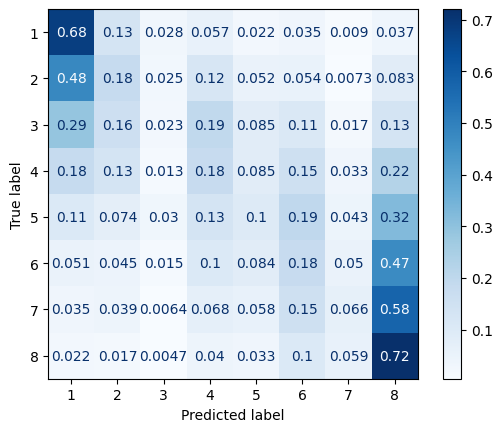

In [22]:
# Random forest

df = df_start
df = df.drop(columns=['puuid', 'match_id', 'played_with_partner', 'augment_1', 'augment_2', 'augment_3', 'top4'])

# train model that predicts placement
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=['placement'])
y = df['placement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf.fit(X_train, y_train)

rf.score(X_test, y_test)

# confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')  # type: ignore


/home/sebastian/dev/teamfight-tactis-data-crawler/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


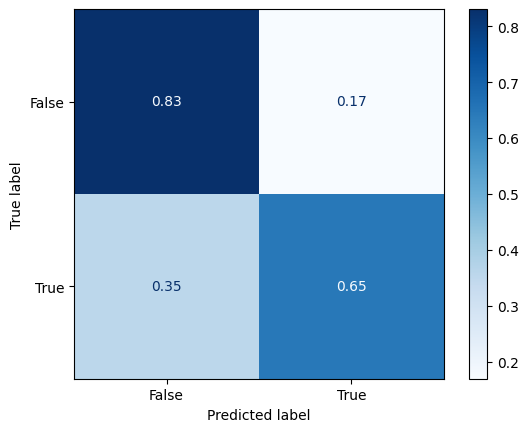

In [51]:
df = df_start

df = df.drop(columns=['puuid', 'match_id', 'played_with_partner', 'augment_1', 'augment_2', 'augment_3', 'placement'])

# train model that predicts top4
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=['top4'])
y = df['top4']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf.fit(X_train, y_train)

rf.score(X_test, y_test)

# confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')  # type: ignore



In [23]:
# get rid of annoying warnings from sklearn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# tune hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [10, 50, None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 250, 1000]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250; total time=   9.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250; total time=   9.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25

KeyboardInterrupt: 

/home/sebastian/dev/teamfight-tactis-data-crawler/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


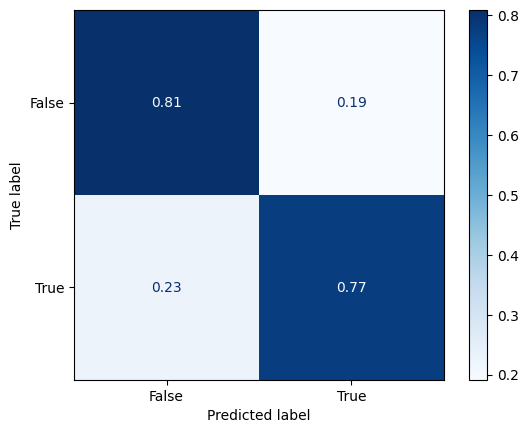

In [24]:
# XGB boost

df = df_start

df = df.drop(columns=['puuid', 'match_id', 'played_with_partner', 'augment_1', 'augment_2', 'augment_3', 'placement'])

# train xgb model that predicts top4
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X = df.drop(columns=['top4'])
y = df['top4']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBClassifier(n_estimators=100, max_depth=10, random_state=0)
xgb.fit(X_train, y_train)

xgb.score(X_test, y_test)

# confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(xgb, X_test, y_test, cmap=plt.cm.Blues, normalize='true')  # type: ignore



In [29]:
# tune hyperparameters of xgb

from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [1, 2, 3, 10],
    'n_estimators': [50, 100, 1000],
}

xgb = XGBClassifier()
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
grid_search.best_params_


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   3.5s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   3.6s
[CV] END ....learning_rate=0.1, max_depth=1, n_estimators=50; total time=   3.6s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   6.1s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   6.7s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   6.5s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=50; total time=   5.5s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=50; total time=   5.6s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=50; total time=   5.4s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=  10.1s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=  11.0s
[CV] END ...learning_rate=0.1, max_depth=2, n_e

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}

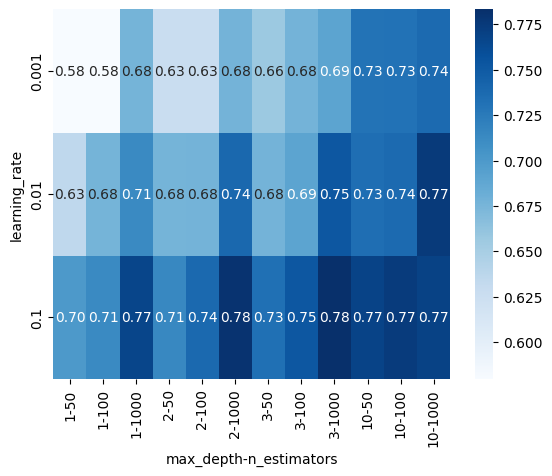

In [30]:
# plot hperparameter tuning results

# n_estimators means number of trees
# max_depth means max depth of each tree
# learning_rate means how much to weight each tree

results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='rank_test_score')
results = results[['param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_score']]
results = results.rename(columns={'param_learning_rate': 'learning_rate', 'param_max_depth': 'max_depth', 'param_n_estimators': 'n_estimators', 'mean_test_score': 'score'})
results = results.pivot_table(index='learning_rate', columns=['max_depth', 'n_estimators'], values='score')
sns.heatmap(results, annot=True, fmt='.2f', cmap='Blues')
plt.show()


In [35]:
# refit model with best params

xgb = XGBClassifier(n_estimators=1000, max_depth=3, learning_rate=0.1, random_state=0)
xgb.fit(X_train, y_train)

xgb.score(X_test, y_test)


0.7958469435370975

/home/sebastian/dev/teamfight-tactis-data-crawler/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


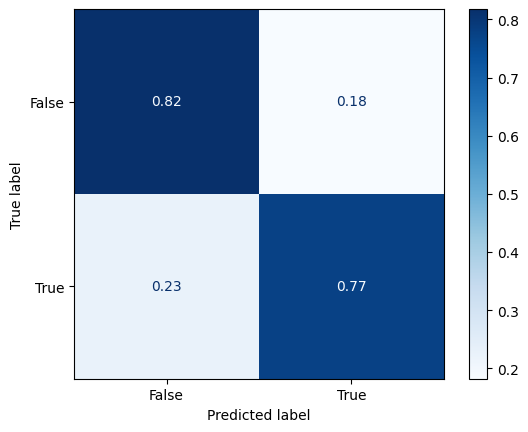

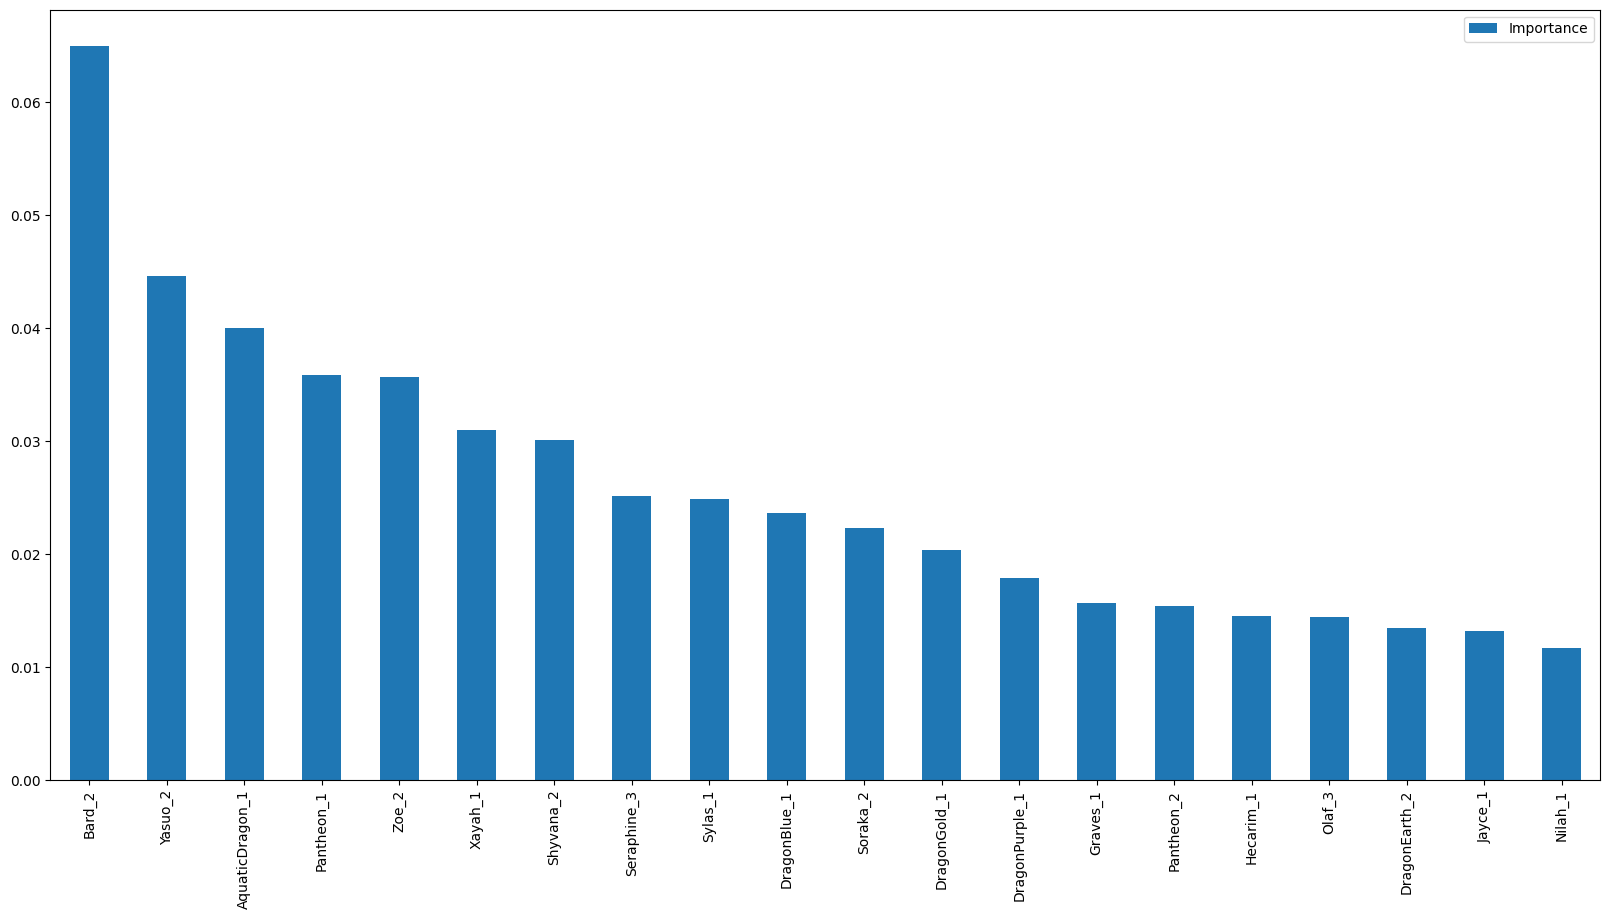

In [36]:
# confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(xgb, X_test, y_test, cmap=plt.cm.Blues, normalize='true')  # type: ignore

# plot feature importance

importance = xgb.feature_importances_
importance = pd.DataFrame(importance, index=X_train.columns, columns=["Importance"])  # type: ignore
importance = importance.sort_values(by='Importance', ascending=False).head(20)
importance.plot(kind='bar', figsize=(20, 10))
plt.show()

/home/sebastian/dev/teamfight-tactis-data-crawler/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


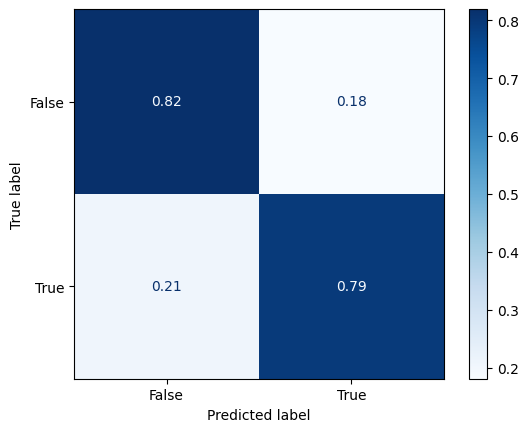

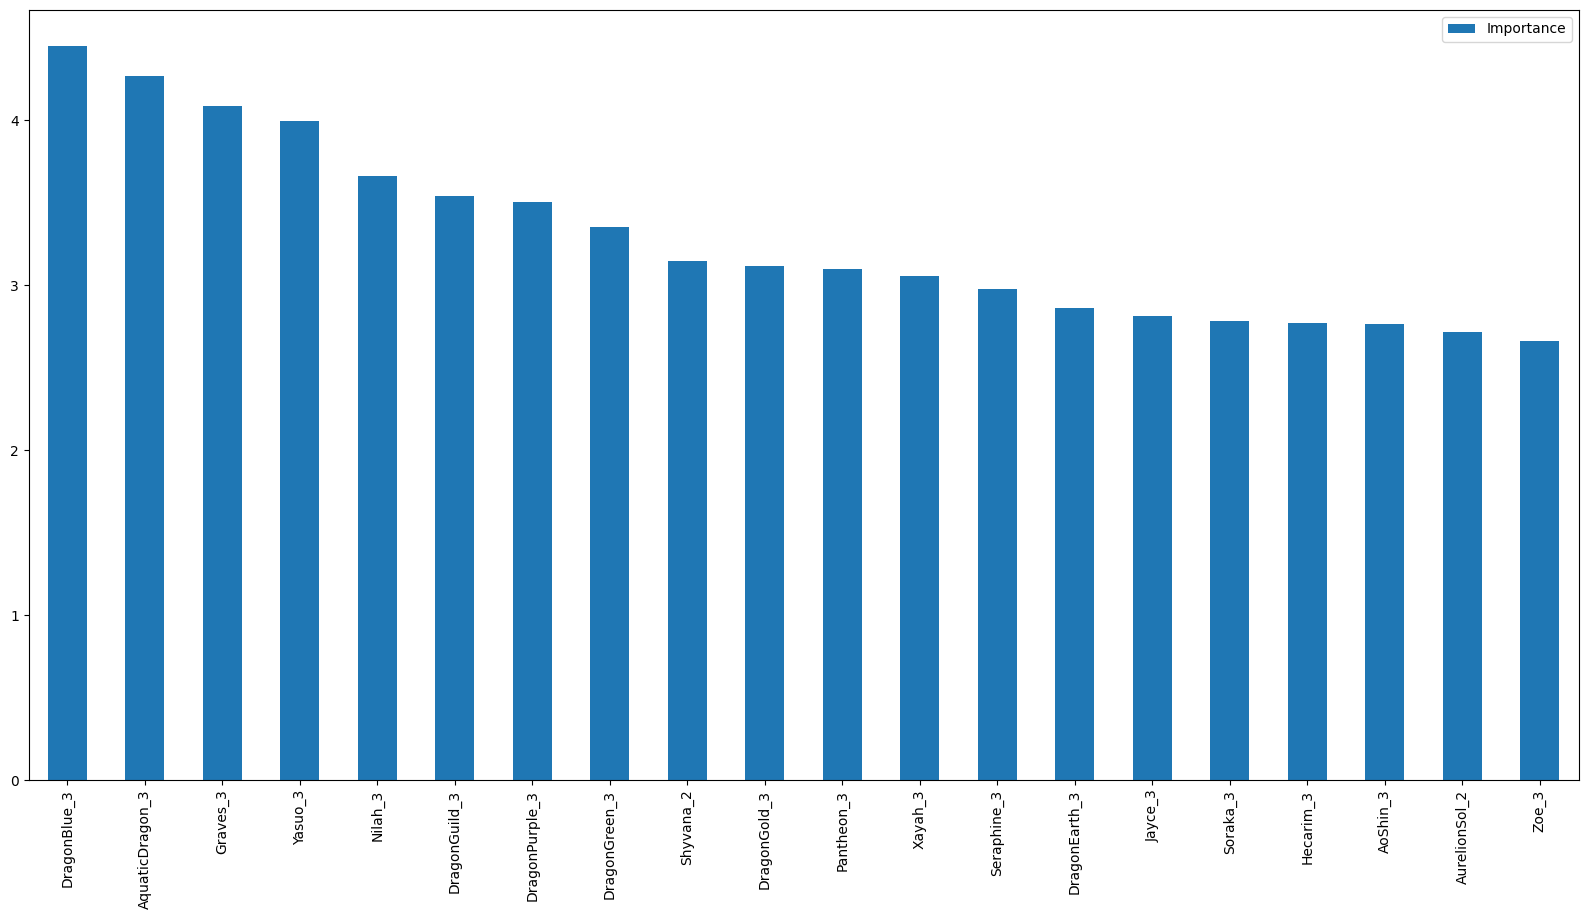

In [38]:
# fit a logistic regression model as a baseline

df = df_start

# train logistic regression model that predicts top4
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

lr.score(X_test, y_test)

# confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr, X_test, y_test, cmap=plt.cm.Blues, normalize='true')  # type: ignore

# plot feature importance

importance = lr.coef_[0]
importance = pd.DataFrame(importance, index=X_train.columns, columns=["Importance"])  # type: ignore
importance = importance.sort_values(by='Importance', ascending=False).head(20)
importance.plot(kind='bar', figsize=(20, 10))
plt.show()



/home/sebastian/dev/teamfight-tactis-data-crawler/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


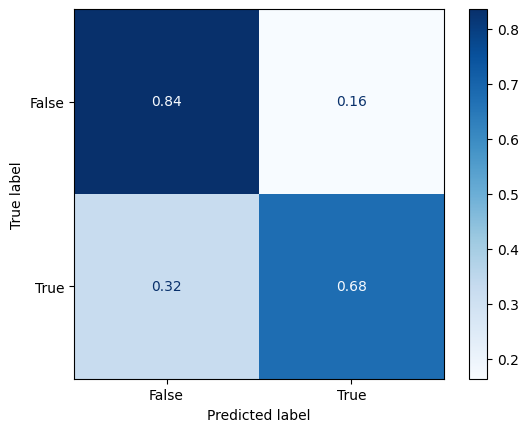

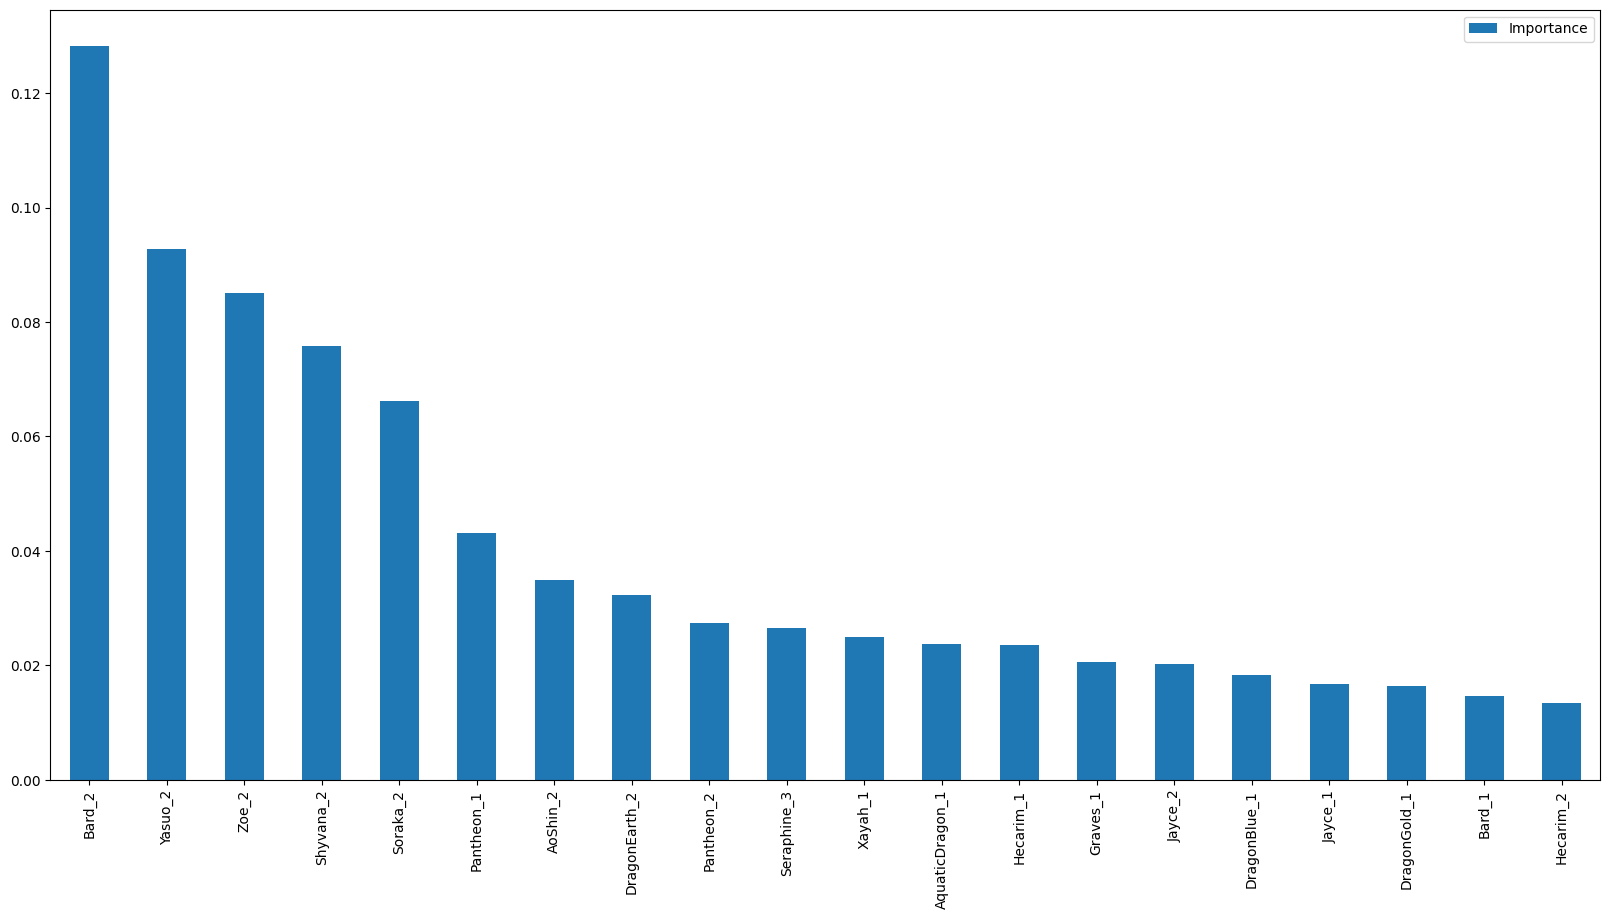

In [46]:
# train a random forest model that predicts top4
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf.fit(X_train, y_train)

rf.score(X_test, y_test)

# confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')  # type: ignore

# plot feature importance

importance = rf.feature_importances_
importance = pd.DataFrame(importance, index=X_train.columns, columns=["Importance"])  # type: ignore
importance = importance.sort_values(by='Importance', ascending=False).head(20)
importance.plot(kind='bar', figsize=(20, 10))
plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.1s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.1s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.7s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.7s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.9s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.9s
[CV] END ......................max_depth=1, n_estimators=100; total time=   1.3s
[CV] END ......................max_depth=1, n_estimators=250; total time=   2.4s
[CV] END ......................max_depth=1, n_estimators=250; total time=   2.1s
[CV] END ......................max_depth=1, n_es

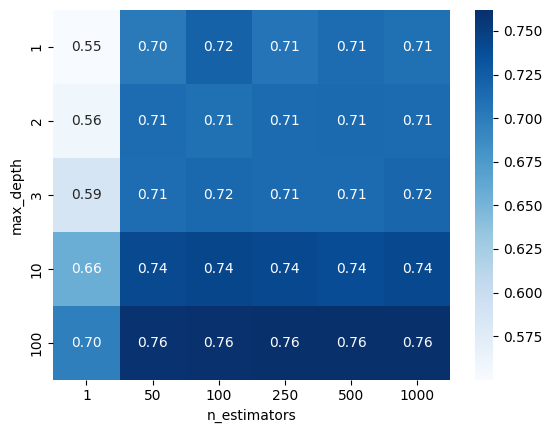

In [48]:
# tune hyperparameters of random forest

from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [1, 2, 3, 10, 100],
    'n_estimators': [1, 50, 100, 250, 500, 1000],
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

